<a href="https://colab.research.google.com/github/slunara/car_damage_detector/blob/main/models/DenseNet121_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Car damage classifier

EfficientNetV2S pre trained model is used to classify where the image contain the damaged car or not.

In [34]:
#import necessary librabry
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Download data


### Kaggle dataset

In [35]:
import kagglehub
import shutil
import os

# Step 1: Download dataset (it will go to /root/.cache/... by default)
dataset_path = kagglehub.dataset_download("anujms/car-damage-detection")
print("Dataset downloaded to:", dataset_path)

# Step 2: Define custom target location
custom_path = "/content/dataset"  # Change this to your desired location

# Step 3: Move dataset from default location to custom location
if os.path.exists(dataset_path):
    shutil.move(dataset_path, custom_path)
    print(f"✅ Dataset successfully moved to {custom_path}")
else:
    print("⚠️ Dataset download failed or path does not exist.")

100%|██████████| 123M/123M [00:00<00:00, 178MB/s]

Extracting files...


Dataset downloaded to: /root/.cache/kagglehub/datasets/anujms/car-damage-detection/versions/1
✅ Dataset successfully moved to /content/dataset


In [36]:
dataset_path = "/content/dataset/data1a"
os.listdir(dataset_path)

['validation', 'training']

In [37]:
train_dir = os.path.join(dataset_path, 'training')
validation_dir = os.path.join(dataset_path, 'validation')

In [38]:
#defining the damage and whole , train and validation directory
train_damage_dir = os.path.join(train_dir, '00-damage')
train_whole_dir = os.path.join(train_dir, '01-whole')
validation_damage_dir = os.path.join(validation_dir, '00-damage')
validation_whole_dir = os.path.join(validation_dir, '01-whole')

In [39]:
def count_images(directory):
    return len([img for img in os.listdir(directory) if os.path.isfile(os.path.join(directory, img))])

# Count images in both categories
num_damage = count_images(train_damage_dir)
num_whole = count_images(train_whole_dir)

print(f"✅ Number of images in 00-damage: {num_damage}")
print(f"✅ Number of images in 01-whole: {num_whole}")

✅ Number of images in 00-damage: 1000
✅ Number of images in 01-whole: 1043


### TQVCD dataset

In [40]:
!rm -rf /content/TQVCD_dataset  # Remove old repo if it exists
!git clone https://github.com/dxlabskku/TQVCD /content/TQVCD_dataset

Cloning into '/content/TQVCD_dataset'...
remote: Enumerating objects: 272, done.
remote: Counting objects: 100% (272/272), done.
remote: Compressing objects: 100% (257/257), done.
remote: Total 272 (delta 30), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (272/272), 21.01 MiB | 19.30 MiB/s, done.
Resolving deltas: 100% (30/30), done.


In [41]:
import os

folder_path = "/content/TQVCD_dataset/RC"  # Adjust if needed

# List everything inside the folder
contents = os.listdir(folder_path)

print(f"📂 Contents of {folder_path}:")
print(contents)


📂 Contents of /content/TQVCD_dataset/RC:
['RC_3.jpg', 'RC_4.jpg', 'RC_10.jpg', 'RC_15.jpg', 'RC_18.jpg', 'RC_14.jpg', 'RC_12.jpg', 'RC_17.jpg', 'RC_20.jpg', 'RC_19.jpg', 'RC_11.jpg', 'RC_9.jpg', 'RC_7.jpg', 'RC_16.jpg', 'RC_5.jpg', 'RC_1.jpg', 'RC_8.jpg', 'RC_2.jpg', 'RC_13.jpg', 'RC_6.jpg']


In [42]:
github_dataset_path = "/content/TQVCD_dataset"

# Define GitHub dataset folder mappings
github_source_folders = {
    "whole": ["FN", "RN"],  # Undamaged cars → move to train_whole_dir
    "damage": ["FB", "FC", "RB", "RC"]  # Damaged cars → move to train_damage_dir
}

In [43]:
# Move images from GitHub dataset to Kaggle dataset directories
def move_all_images(src_root, target_dir):
    for root, _, files in os.walk(src_root):  # Recursively go through subfolders
        for img_name in files:
            img_src = os.path.join(root, img_name)
            img_dst = os.path.join(target_dir, img_name)

            # Prevent overwriting by renaming duplicate images
            if os.path.exists(img_dst):
                base, ext = os.path.splitext(img_name)
                img_dst = os.path.join(target_dir, f"github_{base}{ext}")

            shutil.move(img_src, img_dst)

# Move "whole" (undamaged) images
for folder in ["FN", "RN"]:  # Adjust based on GitHub folder names
    src_path = os.path.join(github_dataset_path, folder)
    if os.path.exists(src_path):
        move_all_images(src_path, train_whole_dir)

# Move "damage" (damaged) images
for folder in ["FB", "FC", "RB", "RC"]:  # Adjust based on GitHub folder names
    src_path = os.path.join(github_dataset_path, folder)
    if os.path.exists(src_path):
        move_all_images(src_path, train_damage_dir)

print("✅ All GitHub dataset images (including subfolders) moved successfully!")


✅ All GitHub dataset images (including subfolders) moved successfully!


In [44]:
# Count images in both categories
num_damage = count_images(train_damage_dir)
num_whole = count_images(train_whole_dir)

print(f"✅ Number of images in 00-damage: {num_damage}")
print(f"✅ Number of images in 01-whole: {num_whole}")


✅ Number of images in 00-damage: 1080
✅ Number of images in 01-whole: 1083


### SURA train dataset

In [45]:
# Clone the GitHub repo
!rm -rf car_damage_detector
repo_url = "https://github.com/slunara/car_damage_detector.git"
!git clone {repo_url}

test_data_dir = "car_damage_detector/all_extracted_images"

assert os.path.exists(test_data_dir), "Train data folder not found!"
print("Train data downloaded successfully!")

Cloning into 'car_damage_detector'...
remote: Enumerating objects: 455, done.
remote: Counting objects: 100% (196/196), done.
remote: Compressing objects: 100% (190/190), done.
remote: Total 455 (delta 51), reused 15 (delta 6), pack-reused 259 (from 3)
Receiving objects: 100% (455/455), 143.74 MiB | 32.31 MiB/s, done.
Resolving deltas: 100% (89/89), done.
Updating files: 100% (246/246), done.
Train data downloaded successfully!


In [46]:
move_all_images(test_data_dir, train_whole_dir)

In [47]:
# Count images in both categories
num_damage = count_images(train_damage_dir)
num_whole = count_images(train_whole_dir)

print(f"✅ Number of images in 00-damage: {num_damage}")
print(f"✅ Number of images in 01-whole: {num_whole}")

✅ Number of images in 00-damage: 1080
✅ Number of images in 01-whole: 1166


## Preprocess the data

Data Augmentation is used to:
1. Rescale the data
2. to bring all the image to same dimension  i.e. 150x150


In [48]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [49]:
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2246 images belonging to 2 classes.
Found 460 images belonging to 2 classes.


## Fine tune EfficientNetV2S

For training 1840 images are used.
For Validation 460 image are used.

Training and evaluating the model with binary crossentropy loss, accuracy, precision , recall.

In [50]:
#defining model
from tensorflow.keras import Model
from tensorflow.keras.applications import DenseNet121
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop

base_model = DenseNet121(input_shape = (150, 150, 3),  include_top = False, weights = 'imagenet')

x=   tf.keras.layers.Flatten()(base_model.output)
x=   tf.keras.layers.Dense(512, activation='relu')(x)
x=   tf.keras.layers.Dense(1, activation='sigmoid')(x)

model= Model( base_model.input, x)

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(learning_rate=1e-4),
              metrics=['Accuracy','Precision','Recall'])

#training the model
history = model.fit(
      train_generator,
      epochs=15,
      validation_data=validation_generator,
      verbose=2)

best_model = model

Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


113/113 - 236s - 2s/step - Accuracy: 0.8464 - Precision: 0.8548 - Recall: 0.8482 - loss: 0.5268 - val_Accuracy: 0.8239 - val_Precision: 0.7475 - val_Recall: 0.9783 - val_loss: 0.7296
Epoch 2/15
113/113 - 13s - 115ms/step - Accuracy: 0.9635 - Precision: 0.9689 - Recall: 0.9605 - loss: 0.0961 - val_Accuracy: 0.9326 - val_Precision: 0.9163 - val_Recall: 0.9522 - val_loss: 0.2901
Epoch 3/15
113/113 - 13s - 115ms/step - Accuracy: 0.9720 - Precision: 0.9750 - Recall: 0.9708 - loss: 0.0744 - val_Accuracy: 0.9152 - val_Precision: 0.8835 - val_Recall: 0.9565 - val_loss: 0.5210
Epoch 4/15
113/113 - 13s - 118ms/step - Accuracy: 0.9840 - Precision: 0.9829 - Recall: 0.9863 - loss: 0.0428 - val_Accuracy: 0.9261 - val_Precision: 0.9083 - val_Recall: 0.9478 - val_loss: 0.5469
Epoch 5/15
113/113 - 13s - 114ms/step - Accuracy: 0.9858 - Precision: 0.9871 - Recall: 0.9854 - loss: 0.0485 - val_Accuracy: 0.9370 - val_Precision: 0.9351 - val_Recall: 0.9391 - val_loss: 0.4698
Epoch 6/15
113/113 - 13s - 114ms/

In [51]:
model=best_model
#weights saving
model.save("classifier.keras")

## TensorFlow Lite Model -- app deployment

Save the best model as TensorFlow Lite Model to deploy it as an app.

In [52]:
train_generator.class_indices

{'00-damage': 0, '01-whole': 1}

In [53]:
if best_model:
    converter = tf.lite.TFLiteConverter.from_keras_model(best_model)
    tflite_model = converter.convert()

    with open("best_model.tflite", "wb") as f:
        f.write(tflite_model)

    print("✅ Best model successfully converted to TensorFlow Lite format!")

    labels = "\n".join(train_generator.class_indices.keys())  # Fix variable reference
    with open("labels.txt", "w") as f:
        f.write(labels)

    print("✅ Labels saved to labels.txt")
else:
    print("⚠️ No best model found! Ensure training completed successfully.")

Saved artifact at '/tmp/tmpw55beauc'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='keras_tensor_430')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  136009602598480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136009602599824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136004560779024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136009602600208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136009602599440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136004560779792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136004560780560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136004560776912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136004560778064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136004560776144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1360045607

## Results

plotting the history of train and validation loss, accurcy, precision, recall

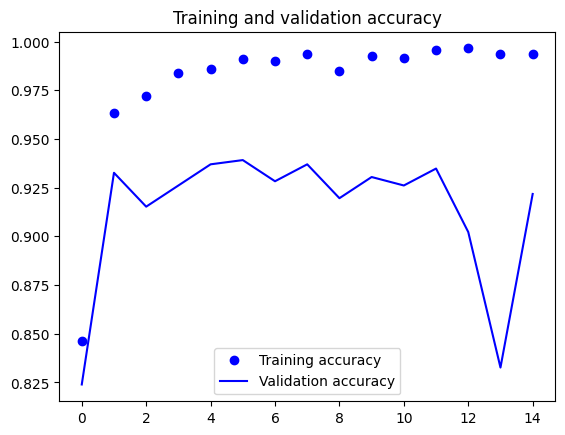

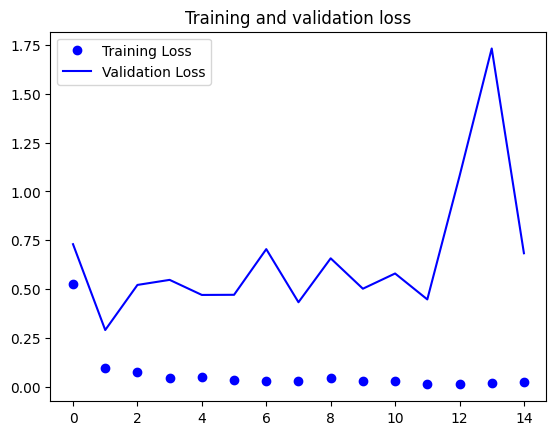

In [54]:
acc = history.history['Accuracy']
val_acc = history.history['val_Accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

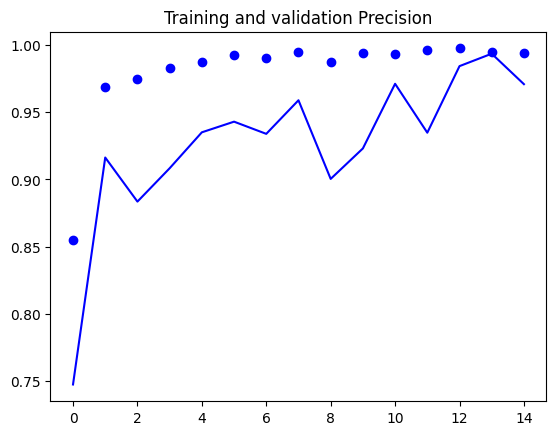

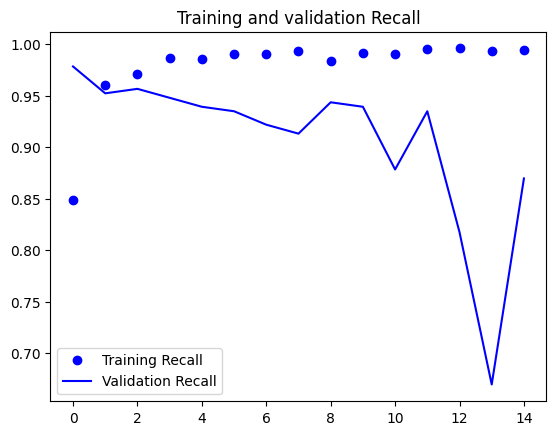

In [55]:

acc = history.history['Precision']
val_acc = history.history['val_Precision']
loss = history.history['Recall']
val_loss = history.history['val_Recall']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Precision')
plt.plot(epochs, val_acc, 'b', label='Validation Precision')
plt.title('Training and validation Precision')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Recall')
plt.plot(epochs, val_loss, 'b', label='Validation Recall')
plt.title('Training and validation Recall')
plt.legend()

plt.show()

Testing

1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
[[0.]]
The car is damaged


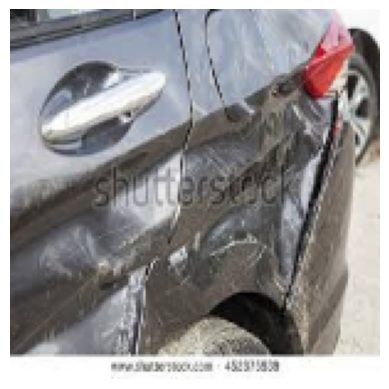

In [56]:
import cv2
im = cv2.imread("/content/dataset/data1a/validation/00-damage/0014.JPEG")
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
im = cv2.resize(im, (150, 150))
imS=im.reshape([1,150,150,3])
pred=model.predict(np.array(imS))
print(pred)
if pred[0][0]<0.5:
    print("The car is damaged")
else:
    print("The car is not damaged")
plt.axis("off")
plt.imshow(im)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
[[1.]]
The car is not damaged


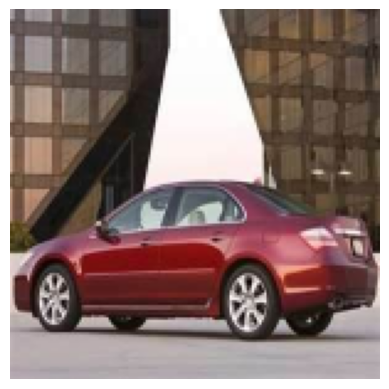

In [57]:
im = cv2.imread("/content/dataset/data1a/validation/01-whole/0001.jpg")
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
im = cv2.resize(im, (150, 150))
imS=im.reshape([1,150,150,3])
pred=model.predict(np.array(imS))
print(pred)
if pred[0][0]<0.5:
    print("The car is damaged")
else:
    print("The car is not damaged")
plt.axis("off")
plt.imshow(im)


Conclusion: Successfully build a classifier to classify the images containing into damage and undamage cars.

# Inference - SURA test dataset

In [76]:
# Clone the GitHub repo
!rm -rf car_damage_detector
repo_url = "https://github.com/slunara/car_damage_detector.git"
!git clone {repo_url}

test_data_dir = "car_damage_detector/test_data"

assert os.path.exists(test_data_dir), "Test data folder not found!"
print("Test data downloaded successfully!")

Cloning into 'car_damage_detector'...
remote: Enumerating objects: 467, done.
remote: Counting objects: 100% (208/208), done.
remote: Compressing objects: 100% (202/202), done.
remote: Total 467 (delta 57), reused 15 (delta 6), pack-reused 259 (from 3)
Receiving objects: 100% (467/467), 143.75 MiB | 28.55 MiB/s, done.
Resolving deltas: 100% (95/95), done.
Updating files: 100% (243/243), done.
Test data downloaded successfully!


In [86]:
import os

folder_path = "car_damage_detector/test_data/damage"  # Adjust if needed

# List everything inside the folder
contents = os.listdir(folder_path)

print(f"📂 Contents of {folder_path}:")
print(contents)


📂 Contents of car_damage_detector/test_data/damage:
['HRT586_Left.jpg', 'Hxv766_vehicle_03022025_081724_Right.jpg', 'HRT586_Front.jpg', 'TMX473_Left.jpg', 'Khn990_vehicle_02022025_090122_Estribo derecho.jpg', 'XCY702_Left.jpg', 'Right.jpg']


In [77]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input


IMG_SIZE = (150, 150)

class_labels = {"damage": 0, "whole": 1}

# Function to load and preprocess images
def load_and_preprocess_image(image_path):
    img = load_img(image_path, target_size=IMG_SIZE)  # Load and resize
    img_array = img_to_array(img)  # Convert to numpy array
    img_array = preprocess_input(img_array)  # Normalize
    return img_array

# Function to load test images from both classes
def load_test_images(test_data_dir):
    test_images = []
    test_labels = []
    test_filenames = []

    for category in ["damage", "whole"]:  # Iterate over both classes
        folder_path = os.path.join(test_data_dir, category)

        for img_name in os.listdir(folder_path):
            img_path = os.path.join(folder_path, img_name)
            img_array = load_and_preprocess_image(img_path)
            test_images.append(img_array)
            test_labels.append(class_labels[category])
            test_filenames.append(img_name)

    return np.array(test_images), np.array(test_labels), test_filenames

X_test, y_test, filenames = load_test_images(test_data_dir)

print(f"Loaded {len(X_test)} test images!")

Loaded 144 test images!


In [78]:
# Make predictions
y_pred = model.predict(X_test)
y_pred_labels = (y_pred > 0.5).astype(int)  # Convert probabilities to binary labels

5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step


In [79]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Assuming y_test and y_pred_labels are already defined
# y_test: True labels (flattened if needed)
# y_pred_labels: Predicted labels

# ✅ Calculate Accuracy
accuracy = accuracy_score(y_test.flatten(), y_pred_labels)

# ✅ Calculate Precision for Class 0 (Damaged Cars)
precision_damage = precision_score(y_test.flatten(), y_pred_labels, pos_label=0)

# ✅ Calculate Recall for Class 0 (Damaged Cars)
recall_damage = recall_score(y_test.flatten(), y_pred_labels, pos_label=0)

# ✅ Print the results
print(f"Model Performance Metrics:")
print(f"Accuracy: {accuracy* 100:.2f}%")
print(f"Precision for Damaged Cars (Class 0): {precision_damage* 100:.2f}%")
print(f"Recall for Damaged Cars (Class 0): {recall_damage* 100:.2f}%")


Model Performance Metrics:
Accuracy: 70.83%
Precision for Damaged Cars (Class 0): 9.30%
Recall for Damaged Cars (Class 0): 57.14%


## Confusion matrix

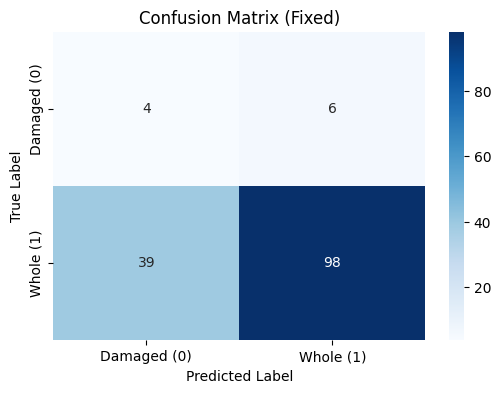

In [62]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


y_pred_labels = y_pred_labels.flatten()

cm = confusion_matrix(y_test, y_pred_labels)

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Damaged (0)", "Whole (1)"],
            yticklabels=["Damaged (0)", "Whole (1)"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Fixed)")
plt.show()

## ROC curve

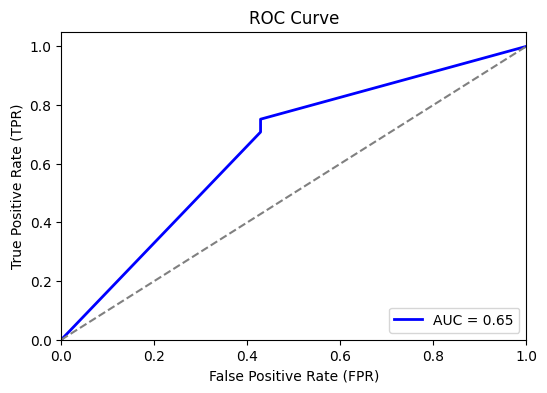

In [80]:
from sklearn.metrics import roc_curve, auc


# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)  # Use probabilities
roc_auc = auc(fpr, tpr)  # Compute AUC

# Plot ROC Curve
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color="blue", lw=2, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")  # Diagonal reference line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

* 0.65 indicates moderate but weak performance, meaning the model has some discriminatory power but needs improvement.

* The blue ROC curve is very close to the diagonal line (random performance).

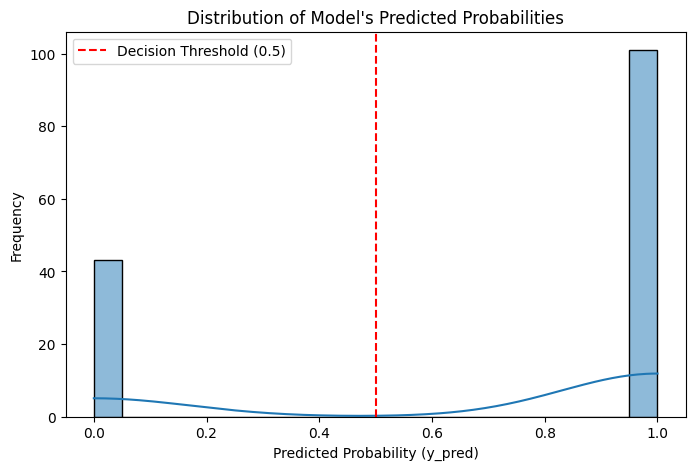

In [81]:
# Plot distribution of predicted probabilities
plt.figure(figsize=(8, 5))
sns.histplot(y_pred, bins=20, kde=True, color="blue")  # Histogram with KDE curve
plt.xlabel("Predicted Probability (y_pred)")
plt.ylabel("Frequency")
plt.title("Distribution of Model's Predicted Probabilities")
plt.axvline(0.5, color="red", linestyle="--", label="Decision Threshold (0.5)")
plt.legend()
plt.show()

## Verify visually the results

In [87]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input



# Define class labels (damage = 0, whole = 1)
class_labels = {"damage": 0, "whole": 1}

# Function to load and preprocess images
def load_and_preprocess_image(image_path):
    img = load_img(image_path, target_size=IMG_SIZE)  # Load and resize
    img_array = img_to_array(img)  # Convert to numpy array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = preprocess_input(img_array)  # Normalize
    return img_array

# Function to load test images from both classes
def load_test_images(test_data_dir):
    test_images = []
    test_labels = []
    test_filenames = []
    test_filepaths = []  # Store full paths for loading images later

    for category in ["damage", "whole"]:  # Iterate over both classes
        folder_path = os.path.join(test_data_dir, category)

        for img_name in os.listdir(folder_path):
            img_path = os.path.join(folder_path, img_name)
            img_array = load_and_preprocess_image(img_path)
            test_images.append(img_array)
            test_labels.append(class_labels[category])
            test_filenames.append(img_name)
            test_filepaths.append(img_path)  # Store full path

    return np.vstack(test_images), np.array(test_labels), test_filenames, test_filepaths

# Load test images
X_test, y_test, filenames, filepaths = load_test_images(test_data_dir)

print(f"✅ Loaded {len(X_test)} test images!")



✅ Loaded 144 test images!


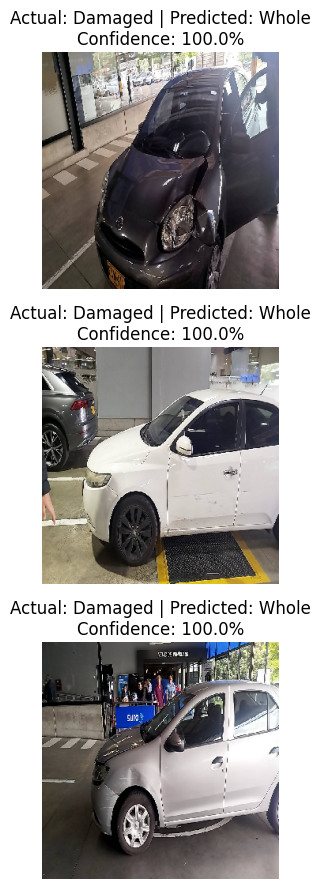

In [94]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img

# 🔍 Identify False Negatives (FN) - Damaged (0) but Predicted as Whole (1)
false_negatives_indices = np.where((y_test == 0) & (y_pred_labels.flatten() == 1))[0]  # FN: Misclassified damaged cars

# 🔹 Get corresponding file paths
false_neg_images = [filepaths[i] for i in false_negatives_indices]
false_neg_actual = [y_test[i] for i in false_negatives_indices]
false_neg_pred = [y_pred_labels[i] for i in false_negatives_indices]
false_neg_probs = [y_pred[i] for i in false_negatives_indices]

# ✅ Check if there are any false negatives before creating subplots
if len(false_neg_images) > 0:
    # ✅ Display the images with their actual & predicted labels
    fig, axes = plt.subplots(nrows=len(false_neg_images), figsize=(8, len(false_neg_images) * 3))

    if len(false_neg_images) == 1:
        axes = [axes]  # Ensure it's iterable for a single image case

    for i, img_path in enumerate(false_neg_images):
        img = load_img(img_path, target_size=(300, 300))  # Load with larger size
        axes[i].imshow(img)
        axes[i].axis("off")

        # Actual & Predicted labels
        actual_label = "Damaged"
        predicted_label = "Whole"

        # Calculate confidence
        probability = false_neg_probs[i][0] * 100  # Confidence in class 1 (Whole)

        # ✅ Set title with confidence score
        axes[i].set_title(f"Actual: {actual_label} | Predicted: {predicted_label}\nConfidence: {probability:.1f}%")

    plt.tight_layout()
    plt.show()
else:
    print("✅ No False Negatives found (No misclassified damaged cars).")


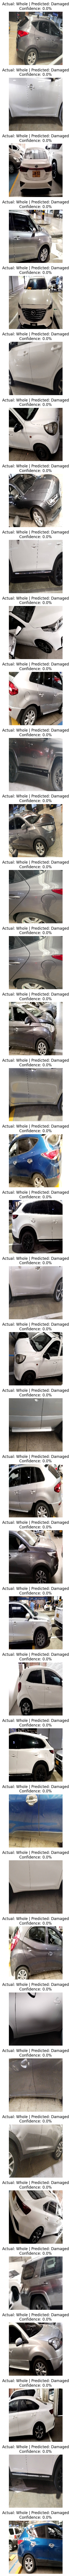

In [96]:

# 🔍 Identify False Negatives (FN) - Damaged (0) but Predicted as Whole (1)
false_negatives_indices = np.where((y_test == 1) & (y_pred_labels.flatten() == 0))[0]  # FN: Misclassified damaged cars

# 🔹 Get corresponding file paths
false_neg_images = [filepaths[i] for i in false_negatives_indices]
false_neg_actual = [y_test[i] for i in false_negatives_indices]
false_neg_pred = [y_pred_labels[i] for i in false_negatives_indices]
false_neg_probs = [y_pred[i] for i in false_negatives_indices]

# ✅ Check if there are any false negatives before creating subplots
if len(false_neg_images) > 0:
    # ✅ Display the images with their actual & predicted labels
    fig, axes = plt.subplots(nrows=len(false_neg_images), figsize=(8, len(false_neg_images) * 3))

    if len(false_neg_images) == 1:
        axes = [axes]  # Ensure it's iterable for a single image case

    for i, img_path in enumerate(false_neg_images):
        img = load_img(img_path, target_size=(300, 300))  # Load with larger size
        axes[i].imshow(img)
        axes[i].axis("off")

        # Actual & Predicted labels
        actual_label = "Whole"
        predicted_label = "Damaged"

        # Calculate confidence
        probability = false_neg_probs[i][0] * 100  # Confidence in class 1 (Whole)

        # ✅ Set title with confidence score
        axes[i].set_title(f"Actual: {actual_label} | Predicted: {predicted_label}\nConfidence: {probability:.1f}%")

    plt.tight_layout()
    plt.show()
else:
    print("✅ No False Negatives found (No misclassified damaged cars).")


In [ ]:
#from google.colab import files

#files.download("best_model.tflite")
#files.download("labels.txt")